In [16]:
import sys
sys.path.append("..")
import torch
from torchvision.models import inception_v3
from torchvision import transforms
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import torch
seed = 42
_ = torch.manual_seed(seed)
from train_utils import create_model, save_model, \
    generate_dataloaders, \
    DEFAULT_OUTPUT_DIMS, save_race_based_predictions, ATTRIBUTE_INDECIES

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
ATTRIBUTE_INDECIES

{'skin_type': 0,
 'lip_type': 1,
 'nose_type': 2,
 'eye_type': 3,
 'hair_type': 4,
 'hair_color': 5}

In [3]:
RFW_IMAGES_DIR =  "/media/global_data/fair_neural_compression_data/datasets/RFW/data_64"
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
DEVICE = 2
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.01
BATCH_SIZE = 32
EPOCHS = 30
kept_features = ['hair_color']

In [4]:
output_dims = {feature: DEFAULT_OUTPUT_DIMS[feature] for feature in kept_features}
model = create_model(
    device, 
    output_dims
)

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Creating a multi-head ResNet18 with the following heads:
	o hair_color


In [5]:
train_loader, val_loader, test_loader = generate_dataloaders(RFW_IMAGES_DIR, BATCH_SIZE, 0.7)

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [15]:
next(iter(train_loader))[1][:, ATTRIBUTE_INDECIES['hair_color']].unique()

tensor([0., 1., 2., 3., 4.])

In [29]:
def train_numerical_rfw(
        model, 
        optimizer,
        num_epochs, 
        lr, 
        train_loader, 
        valid_loader,
        device,
        save_dir,
        patience=5  # Number of epochs to wait for improvement in validation loss before stopping
    ):
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = optimizer(model.parameters(), lr=lr)
    
    train_losses = []
    valid_losses = []
    
    best_valid_loss = float('inf')
    no_improvement_count = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Training") as pbar:
            for inputs, targets, races in train_loader:
                inputs, targets = inputs.to(device).float(), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = 0
                for i, head in enumerate(outputs):
                    loss += criterion(outputs[head], targets[:, ATTRIBUTE_INDECIES[head]].to(torch.int64))
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * inputs.size(0)
                pbar.update(1)
            avg_train_loss = running_train_loss / len(train_loader.dataset)
            pbar.set_postfix(train_loss=avg_train_loss)
        
        print(f'Epoch {epoch + 1} train loss : {avg_train_loss}')
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            with tqdm(total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Validation") as pbar:
                for inputs, targets, races in valid_loader:
                    inputs, targets = inputs.to(device).float(), targets.to(device)
                    outputs = model(inputs)
                    loss = 0
                    for i, head in enumerate(outputs):
                        # print(f'head: {head} - race:{np.unique(np.array(races))},  unique hairs: {targets[:, ATTRIBUTE_INDECIES[head]].unique()}')
                        loss += criterion(outputs[head], targets[:, ATTRIBUTE_INDECIES[head]].to(torch.int64))
                    running_valid_loss += loss.item() * inputs.size(0)
                    pbar.update(1)
                avg_valid_loss = running_valid_loss / len(valid_loader.dataset)  # Compute average validation loss
                pbar.set_postfix(valid_loss=avg_valid_loss)
        print(f'Epoch {epoch + 1} valid loss : {avg_valid_loss}')
        valid_losses.append(avg_valid_loss)
        
        # Check for early stopping
        if avg_valid_loss < best_valid_loss:
            print(f'Found better model. Best loss: {avg_valid_loss}')
            best_valid_loss = avg_valid_loss
            no_improvement_count = 0
            print(f'Saving best model to {save_dir}/best.pth')
            torch.save(model, f'{save_dir}/best.pth')
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    model = torch.load(f'{save_dir}/best.pth')
    return model, train_losses, valid_losses

In [45]:
output_dims = {feature: DEFAULT_OUTPUT_DIMS[feature] for feature in kept_features}
model = create_model(
    device, 
    output_dims
)

Creating a multi-head ResNet18 with the following heads:
	o hair_color


/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
trained_model, train_losses, valid_losses = train_numerical_rfw(
    model, 
    torch.optim.SGD,
    EPOCHS, 
    LEARNING_RATE, 
    train_loader, 
    val_loader,
    device,
    '/home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color',
    patience=5
)

Epoch 1/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.59it/s, train_loss=1.28]


Epoch 1 train loss : 1.283617624356114


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.51it/s, valid_loss=1.28]


Epoch 1 valid loss : 1.2792211523237653
Found better model. Best loss: 1.2792211523237653
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.86it/s, train_loss=1.28]


Epoch 2 train loss : 1.2810229088197853


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.61it/s, valid_loss=1.28]


Epoch 2 valid loss : 1.2790531101846827
Found better model. Best loss: 1.2790531101846827
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.52it/s, train_loss=1.28]


Epoch 3 train loss : 1.2807723856831215


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.51it/s, valid_loss=1.28]


Epoch 3 valid loss : 1.2783671750593335
Found better model. Best loss: 1.2783671750593335
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.97it/s, train_loss=1.27]


Epoch 4 train loss : 1.2669275649460208


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.91it/s, valid_loss=1.25]


Epoch 4 valid loss : 1.2486720933954893
Found better model. Best loss: 1.2486720933954893
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.88it/s, train_loss=1.24]


Epoch 5 train loss : 1.2371160109345758


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.84it/s, valid_loss=1.23]


Epoch 5 valid loss : 1.231673323644282
Found better model. Best loss: 1.231673323644282
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.07it/s, train_loss=1.22]


Epoch 6 train loss : 1.2198123586973002


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.24it/s, valid_loss=1.21]


Epoch 6 valid loss : 1.2108005133976276
Found better model. Best loss: 1.2108005133976276
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.12it/s, train_loss=1.18]


Epoch 7 train loss : 1.1841159441287907


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.98it/s, valid_loss=1.18]


Epoch 7 valid loss : 1.1848720294112858
Found better model. Best loss: 1.1848720294112858
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.07it/s, train_loss=1.16]


Epoch 8 train loss : 1.1570607552620984


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.90it/s, valid_loss=1.18]


Epoch 8 valid loss : 1.17771185740053
Found better model. Best loss: 1.17771185740053
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.96it/s, train_loss=1.14]


Epoch 9 train loss : 1.1371370463045154


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.09it/s, valid_loss=1.17]


Epoch 9 valid loss : 1.171360772694494
Found better model. Best loss: 1.171360772694494
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.91it/s, train_loss=1.12]


Epoch 10 train loss : 1.1232572093736009


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.68it/s, valid_loss=1.17]


Epoch 10 valid loss : 1.1719199591641198


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.87it/s, train_loss=1.11]


Epoch 11 train loss : 1.1074617525036825


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.24it/s, valid_loss=1.17]


Epoch 11 valid loss : 1.1722541970976506


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.66it/s, train_loss=1.09]


Epoch 12 train loss : 1.0923348563240174


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.67it/s, valid_loss=1.17]


Epoch 12 valid loss : 1.166477637618971
Found better model. Best loss: 1.166477637618971
Saving best model to /home/rasta/fair compression/fair-neural-compression-eval/models/converged_models/separate_models/hair_color/best.pth


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.96it/s, train_loss=1.08]


Epoch 13 train loss : 1.0799786741553044


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.50it/s, valid_loss=1.17]


Epoch 13 valid loss : 1.1711824516654308


Epoch 14/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.94it/s, train_loss=1.07]


Epoch 14 train loss : 1.0663120314130774


Epoch 14/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.38it/s, valid_loss=1.17]


Epoch 14 valid loss : 1.1725885344733746


Epoch 15/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.75it/s, train_loss=1.06]


Epoch 15 train loss : 1.056715942086752


Epoch 15/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.00it/s, valid_loss=1.18]


Epoch 15 valid loss : 1.1764465791802163


Epoch 16/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.24it/s, train_loss=1.05]


Epoch 16 train loss : 1.0462577728831932


Epoch 16/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.96it/s, valid_loss=1.17]


Epoch 16 valid loss : 1.1735961971524078


Epoch 17/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.01it/s, train_loss=1.04]


Epoch 17 train loss : 1.0372403366881762


Epoch 17/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.08it/s, valid_loss=1.17]

Epoch 17 valid loss : 1.174178867323648
Early stopping at epoch 17


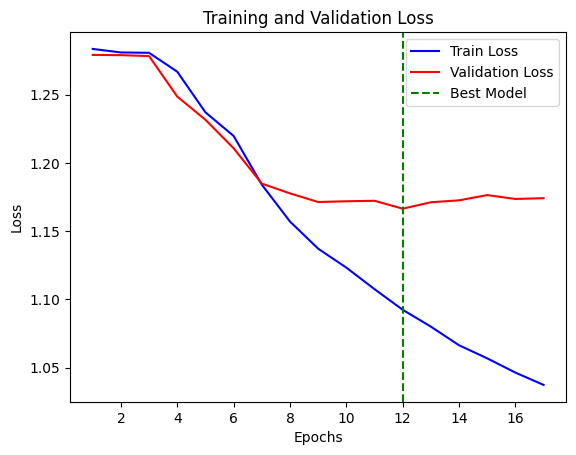

In [47]:
import matplotlib.pyplot as plt

# Sample lists of train and validation losses
# train_losses = [0.5, 0.4, 0.3, 0.2, 0.1]
# val_losses = [0.6, 0.5, 0.4, 0.3, 0.2]

# Plotting
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, valid_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

best_epoch = valid_losses.index(min(valid_losses)) + 1

# Add a vertical line at the epoch with the lowest validation loss
plt.axvline(x=best_epoch, color='g', linestyle='--', label='Best Model')

plt.legend()
plt.show()

In [48]:
preds, labels = save_race_based_predictions(
    model,  
    test_loader, 
    device, 
    '/media/global_data/fair_neural_compression_data/predictions/clean'
)

prediction_save_dir: /media/global_data/fair_neural_compression_data/predictions/clean


Getting Predictions: 100%|██████████| 191/191 [00:04<00:00, 40.73batch/s]


In [34]:
labels.keys()

dict_keys(['Indian', 'Caucasian', 'Asian', 'African'])

In [49]:
for race in labels: 
    print(f'RACE: {race}')
    print(classification_report(labels[race]['hair_color'], preds[race]['hair_color']))
    print(f'######################')

RACE: Indian
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      1059
         1.0       0.72      0.60      0.65       275
         2.0       0.34      0.30      0.32       266
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         8

    accuracy                           0.69      1612
   macro avg       0.36      0.35      0.35      1612
weighted avg       0.68      0.69      0.69      1612

######################
RACE: Caucasian
              precision    recall  f1-score   support

         0.0       0.41      0.39      0.40       315
         1.0       0.57      0.60      0.59       219
         2.0       0.55      0.63      0.59       593
         3.0       0.67      0.56      0.61       302
         4.0       0.00      0.00      0.00        38

    accuracy                           0.54      1467
   macro avg       0.44      0.44      0.44      1467
weighted avg       0.53  

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [17]:
labels

{'Indian': {'hair_color': tensor([2., 4., 2.,  ..., 2., 2., 2.])},
 'Caucasian': {'hair_color': tensor([4., 3., 4.,  ..., 4., 3., 4.])},
 'Asian': {'hair_color': tensor([2., 2., 3.,  ..., 4., 2., 4.])},
 'African': {'hair_color': tensor([1., 0., 1.,  ..., 0., 1., 1.])}}

In [27]:
preds['Asian']['hair_color'].unique()

tensor([0., 1., 2., 3.])

In [29]:
labels['Caucasian']['hair_color'].unique()

tensor([2., 3., 4., 5.])

In [30]:
prediction_save_dir = '/media/global_data/fair_neural_compression_data/predictions/clean'
all_predictions = {'Indian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                    'Caucasian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                    'Asian': {head: torch.tensor([]) for head in model.heads.keys()},  
                    'African': {head: torch.tensor([]) for head in model.heads.keys()}}
all_labels = {'Indian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                'Caucasian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                'Asian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                'African': {head: torch.tensor([]) for head in model.heads.keys()}}

print(f'prediction_save_dir: {prediction_save_dir}')
dataloader = tqdm(test_loader, desc="Getting Predictions", unit="batch")
model.eval()
with torch.no_grad():
    for _, data in enumerate(dataloader):
        inputs, labels, race = data
        race = np.array(race)

        inputs = inputs.to(torch.float).to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        for i, (head, predictions) in enumerate(outputs.items()):
            head_preds = predictions.argmax(dim=1).cpu()

            for race_label in all_labels:
                race_indices = np.array((race == race_label).nonzero()[0])
                race_predictions = head_preds[race_indices]
                race_labels = labels[:, ATTRIBUTE_INDECIES[head]][race_indices]
            
                all_predictions[race_label][head] = torch.cat((all_predictions[race_label][head], race_predictions.to('cpu')), dim=0)
                all_labels[race_label][head] = torch.cat((all_labels[race_label][head], race_labels.to('cpu')), dim=0)

    # with open(prediction_save_dir + '/predictions.pkl', 'wb+') as f:
    #     pickle.dump(all_predictions, f)
    #with open(prediction_save_dir + '/labels.pkl', 'wb+') as f:
    #    pickle.dump(all_labels, f)


    # return all_predictions, all_labels

prediction_save_dir: /media/global_data/fair_neural_compression_data/predictions/clean


Getting Predictions: 100%|██████████| 191/191 [00:04<00:00, 38.30batch/s]


In [33]:
all_predictions['Asian']['hair_color'].unique()

tensor([0., 1., 2., 3.])

In [32]:
all_labels['Caucasian']['hair_color'].unique()

tensor([0., 1., 2., 3., 4.])

In [34]:
ATTRIBUTE_INDECIES[head]

5